Hamiltonian Monte Carlo (HMC) is a method for sampling from a distribution using discrete-time leapfrog steps. This notebook is a sanity check/demo of the dynamics in a very simple Gaussian case.

In [1]:
import torch
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline


# Define log prob and grad log prob for a standard normal
def log_prob(x):
    return -1/2*torch.sum(x*x)


def grad_log_prob(x):
    return -x

Run uncorrected dynamics and see that they are slightly incorrect

In [2]:
def run_uncorrected(n_samples, dt, leapfrogs, mass=1.):
    x = torch.randn(2)
    x_samples = torch.zeros(n_samples, 2)
    
    for i in range(n_samples):
        p = torch.randn(2) * sqrt(mass)
        for j in range(leapfrogs):
            p_half = p + (dt/2) * grad_log_prob(x)
            x = x + dt * p_half / mass
            p = p_half + (dt/2) * grad_log_prob(x)

        x_samples[i, :] = x

    return x_samples

In [3]:
dt_vals = [.1, .1, .2]
m_vals = [2., 1., 1.]
samples = 1000
runs = 20
means = torch.zeros(len(dt_vals), runs)
stds = torch.zeros(len(dt_vals), runs)
for i, (dt, m) in enumerate(zip(dt_vals, m_vals)):
    for j in range(runs):
        x = run_uncorrected(samples, dt, 20, m)
        means[i, j] = x[:,0].mean()
        stds[i, j] = x[:,0].std()

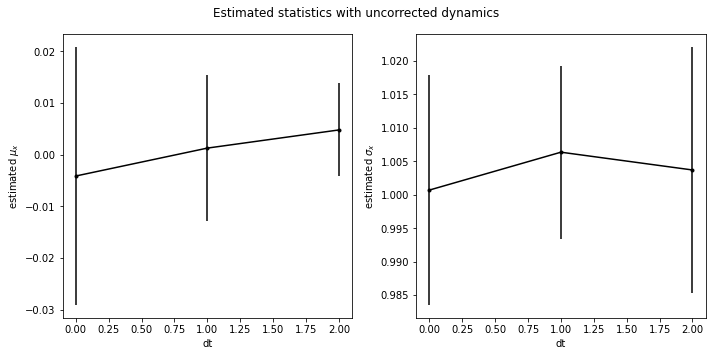

In [4]:
def sem_plot(vals, ax):
    mu = vals.mean(dim=1)
    sem = vals.std(dim=1) / sqrt(vals.size(1))
    ax.errorbar(x=torch.arange(len(mu)), y=mu, yerr=sem*3, marker='.', color='k')

fig, ax = plt.subplots(1,2,figsize=(10, 5))
sem_plot(means, ax[0])
ax[0].set_xlabel('dt')
ax[0].set_ylabel(r'estimated $\mu_x$')
sem_plot(stds, ax[1])
ax[1].set_xlabel('dt')
ax[1].set_ylabel(r'estimated $\sigma_x$')
fig.suptitle('Estimated statistics with uncorrected dynamics')
fig.tight_layout()

Now run with Metropolis correction

In [8]:
def run_hmc(n_samples, dt, leapfrogs, mass=1.):
    x = torch.randn(2)
    x_samples = torch.zeros(n_samples, 2)
    u = torch.rand(n_samples).log()
    
    def h(x,p):
        return torch.sum(p*p)/mass/2 - log_prob(x)
    
    for i in range(n_samples):
        new_x, p = x.clone(), torch.randn(2) * sqrt(mass)
        new_p = p + (dt/2) * grad_log_prob(new_x)
        for j in range(leapfrogs):
            new_x = new_x + dt * new_p / mass
            new_p = new_p + dt * grad_log_prob(new_x)
        new_p = new_p - (dt/2) * grad_log_prob(new_x)

        log_metropolis_ratio = h(new_x, new_p) - h(x, p)
        if log_metropolis_ratio > u[i]:
            x = new_x

        x_samples[i, :] = x

    return x_samples

In [9]:
hmc_means = torch.zeros(len(dt_vals), runs)
hmc_stds = torch.zeros(len(dt_vals), runs)
for i, (dt, m) in enumerate(zip(dt_vals, m_vals)):
    for j in range(runs):
        x = run_hmc(samples, dt, 20, m)
        hmc_means[i, j] = x[:,0].mean()
        hmc_stds[i, j] = x[:,0].std()

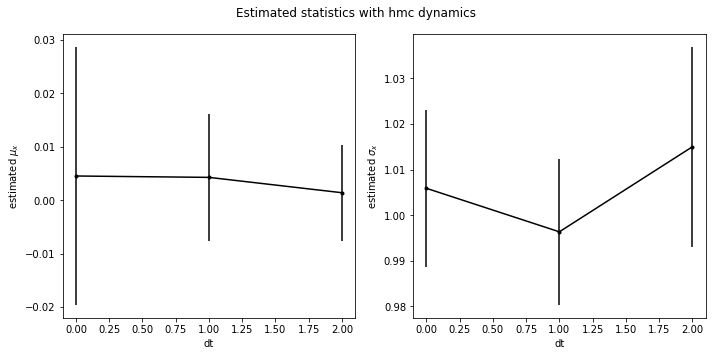

In [10]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
sem_plot(hmc_means, ax[0])
ax[0].set_xlabel('dt')
ax[0].set_ylabel(r'estimated $\mu_x$')
sem_plot(hmc_stds, ax[1])
ax[1].set_xlabel('dt')
ax[1].set_ylabel(r'estimated $\sigma_x$')
fig.suptitle('Estimated statistics with hmc dynamics')
fig.tight_layout()